In [21]:
from CloseToAttack import calculate_distance
from datetime import timedelta
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sb
import sys
sys.path.append('../rovbase')


In [16]:
df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

df = pd.concat(files, axis=0, ignore_index=True)
df1 = df.loc[:,['altitude', 'angle', 'velocity', 'temperature', 'attack']]

attack_df = df1[df1['attack'] == 1]
no_attack_df = df1[df1['attack'] == 0]

attack_data = pd.read_csv('../data/rovbase/rovviltskader.csv')


In [4]:
print(attack_df.describe())
print(attack_df.describe())


          altitude        angle     velocity  temperature  attack
count  3386.000000  3386.000000  3386.000000  3386.000000  3386.0
mean    400.976533   103.033831    76.668340    11.703308     1.0
std     203.106494    55.881343   125.444268     4.628056     0.0
min     185.020000     0.000000     0.000000     0.300000     1.0
25%     230.182500    53.554898    10.000000     8.500000     1.0
50%     335.085000   112.910731    31.000000    10.900000     1.0
75%     482.150000   153.744972    95.000000    14.400000     1.0
max     829.240000   180.000000  2338.000000    25.100000     1.0


In [19]:


# Create flock that is nearby an attack, return list of individuals in the flock
def create_flock(sheep_data, attack):

    # Get attack start and end date
    attack_start_date = attack['date_from'].date()
    attack_end_date = attack['date_to'].date()

    # Only sheep in an attack will be in a flock nearby an attack
    sheep_data = sheep_data[sheep_data['attack'] == 1]

    # Each index corresponds to a row in the sheep data where date is within the attack dates
    sheep_indexes = sheep_data.loc[(attack_start_date <= sheep_data['date']) & (
        sheep_data['date'] <= attack_end_date)].index

    flock = []  # the flock nearby the attack

    for sheep in sheep_indexes:
        # Get latitude and longitude for sheep and attack
        sheep_lat = sheep_data.at[sheep, 'latitude']
        sheep_long = sheep_data.at[sheep, 'longitude']
        attack_lat = attack['latitude']
        attack_long = attack['longitude']

        # Calculate the distance from the sheep to the attack
        distance_to_attack = calculate_distance(
            sheep_lat, sheep_long, attack_lat, attack_long)

        if distance_to_attack <= 1500:  # The sheep is nearby the attack
            ind = sheep_data.at[sheep, 'individual']
            if ind not in flock:
                flock.append(ind)

    return flock


In [13]:
# Return empty dataframe with feature-specific dataframe
def create_empty_mean_std_df(feature):
    mean = 'mean_{f}'.format(f=feature)
    std = 'std_{f}'.format(f=feature)
    bmean = 'before_mean_{f}'.format(f=feature)
    bstd = 'before_std_{f}'.format(f=feature)
    amean = 'after_mean_{f}'.format(f=feature)
    astd = 'after_std_{f}'.format(f=feature)

    # id = rovbaseid, num_ind = number of individs in that attack-flock
    df = pd.DataFrame(columns=['id', 'num_ind', mean,
                      std, bmean, bstd, amean, astd])
    return df

# Return a list with all the values for means and std day before, during, and after attack based on feature-param


def get_mean_std_values(sheep_data, flock, attack, feature):
    attack_start_date = attack['date_from'].date()
    attack_end_date = attack['date_to'].date()

    day_before = attack_start_date - timedelta(days=1)
    day_after = attack_end_date + timedelta(days=1)

    on_attack_feature = pd.Series(dtype='int64')
    before_feature = pd.Series(dtype='int64')
    after_feature = pd.Series(dtype='int64')

    for ind in flock:  # Loop through to get the feature from every sheep in the flock before and after attack
        on_attack = sheep_data.loc[(attack_start_date <= sheep_data['date']) & (
            sheep_data['date'] <= attack_end_date) & (sheep_data['individual'] == ind)]
        before = sheep_data.loc[(sheep_data['date'] == day_before) & (
            sheep_data['individual'] == ind)]
        after = sheep_data.loc[(sheep_data['date'] == day_after) & (
            sheep_data['individual'] == ind)]

        if len(on_attack) > 0:
            on_attack_feature = pd.concat(
                [on_attack_feature, on_attack[feature]])
        if len(before) > 0:
            before_feature = pd.concat([before_feature, before[feature]])
        if len(after) > 0:
            after_feature = pd.concat([after_feature, after[feature]])

    # On attack date
    attack_mean = on_attack_feature.mean()
    attack_std = on_attack_feature.std()

    # On before date
    before_mean = before_feature.mean()
    before_std = before_feature.std()

    # On after date
    after_mean = after_feature.mean()
    after_std = after_feature.std()

    rovId = attack['RovbaseID']

    r = [rovId, len(flock), attack_mean, attack_std,
         before_mean, before_std, after_mean, after_std]
    return r


In [14]:
def create_mean_std_dfs(sheep_data, attack_data):
    attack_data['date_from'] = pd.to_datetime(attack_data['date_from'])
    attack_data['date_to'] = pd.to_datetime(attack_data['date_to'])

    # create new column with only date
    sheep_data['date'] = pd.to_datetime(sheep_data['date_time']).dt.date

    velocity_df = create_empty_mean_std_df('velocity')
    angle_df = create_empty_mean_std_df('angle')
    altitude_df = create_empty_mean_std_df('altitude')

    for a in attack_data.index:
        attack = attack_data.iloc[a]  # Get attack row
        flock = create_flock(sheep_data, attack)

        if len(flock) != 0:
            new_velocity_row = get_mean_std_values(
                sheep_data, flock, attack, 'velocity')
            new_angle_row = get_mean_std_values(
                sheep_data, flock, attack, 'angle')
            new_altitude_row = get_mean_std_values(
                sheep_data, flock, attack, 'altitude')
            velocity_df.loc[len(velocity_df.index)] = new_velocity_row
            angle_df.loc[len(angle_df.index)] = new_angle_row
            altitude_df.loc[len(altitude_df.index)] = new_altitude_row

    return velocity_df, angle_df, altitude_df


In [15]:
def create_means(df_flokk, feature):
    before = 'before_{feature}'.format(feature=feature)
    after = 'after_{feature}'.format(feature=feature)

    org_mean = df_flokk[feature].mean()
    before_mean = df_flokk[before].mean()
    after_mean = df_flokk[after].mean()
    return [before_mean, org_mean, after_mean]


def create_stdev(df_flokk, feature):
    before = 'before_{feature}'.format(feature=feature)
    after = 'after_{feature}'.format(feature=feature)

    org_stdev = df_flokk[feature].std()
    before_stdev = df_flokk[before].std()
    after_stdev = df_flokk[after].std()
    return [before_stdev, org_stdev, after_stdev]


def create_fig(list, year, feature, text):
    print(list)
    fig = px.bar(list, width=800, height=500, title='{text} {feature} for the day before, during and after attack for {year}'.format(
        text=text, feature=feature, year=year))
    fig.update_layout(
        xaxis_title="Dager",
        yaxis_title="{text} {feature}".format(text=text, feature=feature),
        xaxis=dict(
            tickmode='array',
            tickvals=[0, 1, 2],
            ticktext=['før', 'angrepsdagen', 'etter']
        )
    )
    fig.show()


# For all data

In [20]:
velocity_df, angle_df, altitude_df = create_mean_std_dfs(
    sheep_data=df, attack_data=attack_data)


In [22]:
velocity_df = velocity_df.drop_duplicates(['num_ind', 'mean_velocity', 'std_velocity', 'before_mean_velocity',
                                          'before_std_velocity', 'after_mean_velocity', 'after_std_velocity'], ignore_index=True)
angle_df = angle_df.drop_duplicates(['num_ind', 'mean_angle', 'std_angle', 'before_mean_angle',
                                    'before_std_angle', 'after_mean_angle', 'after_std_angle'], ignore_index=True)
altitude_df = altitude_df.drop_duplicates(['num_ind',  'mean_altitude', 'std_altitude', 'before_mean_altitude',
                                          'before_std_altitude', 'after_mean_altitude', 'after_std_altitude'], ignore_index=True)


## Velocity

Text(0, 0.5, 'Velocity')

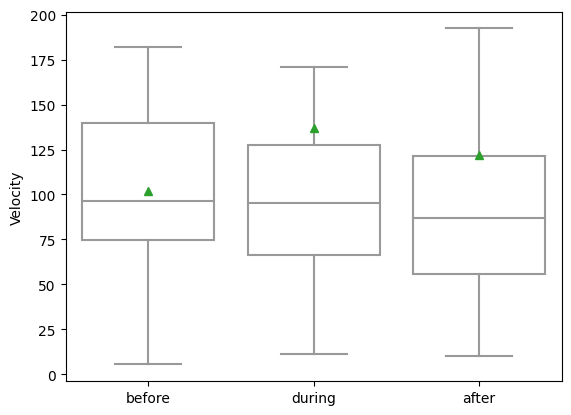

In [23]:
vel = velocity_df.loc[:, ['before_mean_velocity',
                          'mean_velocity', 'after_mean_velocity']]
vel = vel.rename(columns={
                 'before_mean_velocity': 'before', 'mean_velocity': 'during', 'after_mean_velocity': 'after'})


ax = sb.boxplot(data=vel,
                showfliers=False, showmeans=True, color="White")
ax.set_ylabel('Velocity')


# Angle

Text(0, 0.5, 'Angle')

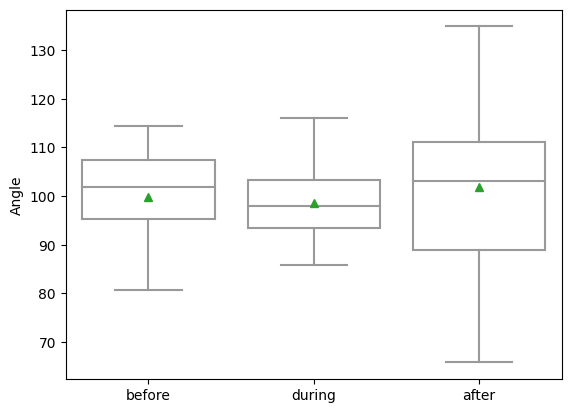

In [25]:
angle = angle_df.loc[:, ['before_mean_angle',
                         'mean_angle', 'after_mean_angle']]
angle = angle.rename(columns={
    'before_mean_angle': 'before', 'mean_angle': 'during', 'after_mean_angle': 'after'})


ax = sb.boxplot(data=angle,
                showfliers=False, showmeans=True, color="White")
ax.set_ylabel('Angle')


# Altitude

Text(0, 0.5, 'Altitude')

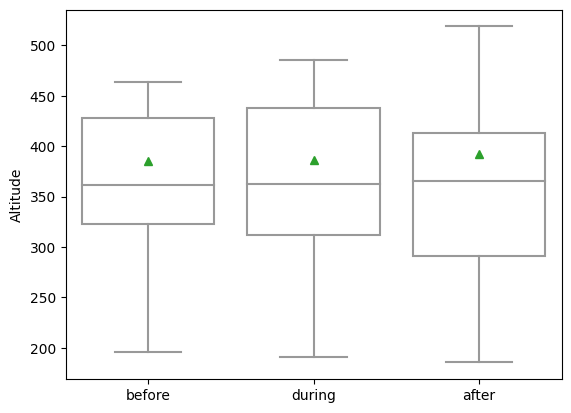

In [24]:
altitude = altitude_df.loc[:, ['before_mean_altitude',
                               'mean_altitude', 'after_mean_altitude']]
altitude = altitude.rename(columns={
    'before_mean_altitude': 'before', 'mean_altitude': 'during', 'after_mean_altitude': 'after'})

ax = sb.boxplot(data=altitude,
                showfliers=False, showmeans=True, color="White")
ax.set_ylabel('Altitude')
